In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    roc_auc_score
)
import joblib
import os
import warnings
import matplotlib.pyplot as plt

In [2]:

# Function to check if CUDA is available
def check_cuda_available():
    """Check if CUDA is available for GPU training."""
    try:
        import xgboost as xgb
        params = {'tree_method': 'gpu_hist'}
        dtrain = xgb.DMatrix(np.random.rand(10, 10), label=np.random.randint(2, size=10))
        booster = xgb.train(params, dtrain, num_boost_round=1)
        return True
    except Exception:
        return False

# Check CUDA availability
cuda_available = check_cuda_available()
print(f"CUDA Available: {cuda_available}")

CUDA Available: False


C:\Users\carol\anaconda3\envs\heartbeat\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:18:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\carol\anaconda3\envs\heartbeat\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:18:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
C:\Users\carol\anaconda3\envs\heartbeat\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:18:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboo

In [41]:
warnings.filterwarnings("ignore")

In [3]:
DATA_PATH = '../data/raw/'
MODEL_PATH = '../models/'
SAMPLING_STRATEGY = 'oversample'
GRID_SEARCH = False 

In [4]:
# Load datasets
def load_datasets():
    """Load and combine datasets."""
    mitbih_train = pd.read_csv(os.path.join(DATA_PATH, 'mitbih_train.csv'), header=None)
    mitbih_test = pd.read_csv(os.path.join(DATA_PATH, 'mitbih_test.csv'), header=None)
    ptbdb_abnormal = pd.read_csv(os.path.join(DATA_PATH, 'ptbdb_abnormal.csv'), header=None)
    ptbdb_normal = pd.read_csv(os.path.join(DATA_PATH, 'ptbdb_normal.csv'), header=None)

    # Combine and shuffle MIT-BIH data
    mitbih_data = pd.concat([mitbih_train, mitbih_test], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Combine and shuffle PTBDB data
    ptbdb_data = pd.concat([ptbdb_abnormal, ptbdb_normal], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

    return mitbih_data, ptbdb_data

mitbih_data, ptbdb_data = load_datasets()

In [5]:
# Extract features and labels
def extract_features_labels(data):
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    return X, y

X_mitbih, y_mitbih = extract_features_labels(mitbih_data)
X_ptbdb, y_ptbdb = extract_features_labels(ptbdb_data)

In [45]:
# Normalize data
def normalize_data(X_train, X_test):
    """Normalize data using StandardScaler."""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# Split datasets into training and testing sets
X_train_mitbih, X_test_mitbih, y_train_mitbih, y_test_mitbih = train_test_split(
    X_mitbih, y_mitbih, test_size=0.2, random_state=42
)
X_train_ptbdb, X_test_ptbdb, y_train_ptbdb, y_test_ptbdb = train_test_split(
    X_ptbdb, y_ptbdb, test_size=0.2, random_state=42
)

# Normalize datasets
X_train_mitbih, X_test_mitbih = normalize_data(X_train_mitbih, X_test_mitbih)
X_train_ptbdb, X_test_ptbdb = normalize_data(X_train_ptbdb, X_test_ptbdb)

In [46]:
# Apply sampling strategy
def apply_sampling(X_train, y_train, strategy='oversample'):
    if strategy == 'oversample':
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X_train, y_train)
    else:
        rus = RandomUnderSampler(random_state=42)
        X_res, y_res = rus.fit_resample(X_train, y_train)
    return X_res, y_res


X_train_res_mitbih, y_train_res_mitbih = apply_sampling(X_train_mitbih, y_train_mitbih, SAMPLING_STRATEGY)
X_train_res_ptbdb, y_train_res_ptbdb = apply_sampling(X_train_ptbdb, y_train_ptbdb, SAMPLING_STRATEGY)

Training Accuracy for MIT-BIH: 1.0
Test Accuracy for MIT-BIH: 0.9848789401553221
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     18152
         1.0       0.89      0.81      0.84       593
         2.0       0.96      0.96      0.96      1433
         3.0       0.83      0.78      0.80       152
         4.0       0.99      0.99      0.99      1560

    accuracy                           0.98     21890
   macro avg       0.93      0.90      0.92     21890
weighted avg       0.98      0.98      0.98     21890



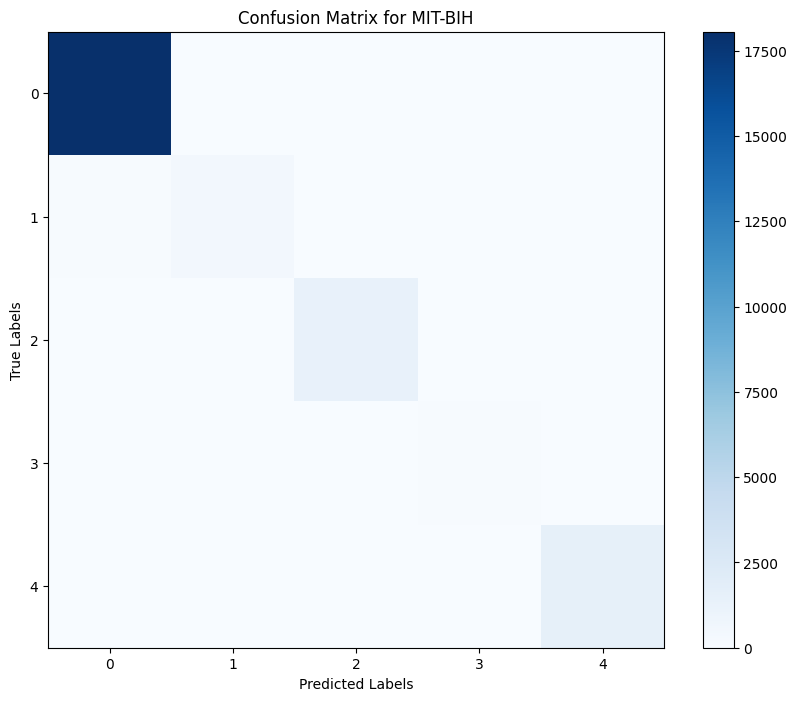

AUC-ROC Score for MIT-BIH: 0.995248553536701

Training Accuracy for PTBDB: 1.0
Test Accuracy for PTBDB: 0.9838543455857094
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       806
         1.0       0.99      0.99      0.99      2105

    accuracy                           0.98      2911
   macro avg       0.98      0.98      0.98      2911
weighted avg       0.98      0.98      0.98      2911



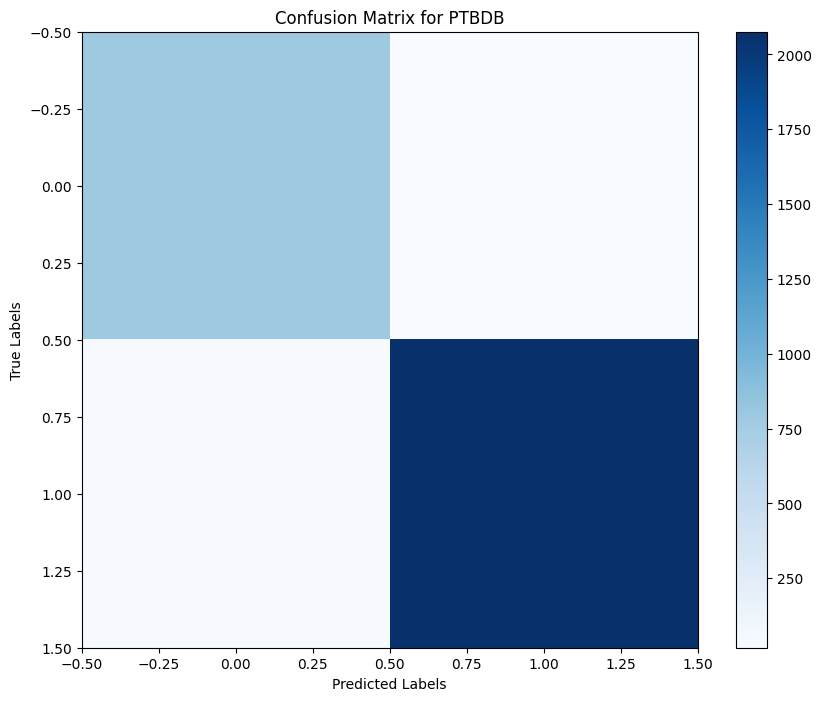

AUC-ROC Score for PTBDB: 0.9968514054331232



In [47]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test, dataset_name):

    # Initialize the XGBoost classifier with default hyperparameters
    xgb_model = XGBClassifier(
        learning_rate=0.1,
        n_estimators=2500,
        max_depth=10,
        gamma=0,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=2
    )
    
    # Use GPU acceleration if available; otherwise, use all CPU cores
    if cuda_available:
        xgb_model.set_params(tree_method='gpu_hist')
    else:
        xgb_model.set_params(n_jobs=-1)
    
    # Perform hyperparameter tuning using GridSearchCV if enabled
    if GRID_SEARCH:
        param_grid = {
            'learning_rate': [0.05, 0.1, 0.2],
            'n_estimators': [1000, 2000, 2500],
            'max_depth': [5, 10, 20]
        }
        grid_search_model = GridSearchCV(xgb_model, param_grid, cv=3, scoring='accuracy', verbose=1)
        grid_search_model.fit(X_train, y_train)
        best_model = grid_search_model.best_estimator_
    else:
        best_model = xgb_model
        best_model.fit(X_train, y_train)
    
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    print(f"Training Accuracy for {dataset_name}: {accuracy_score(y_train, y_train_pred)}")
    print(f"Test Accuracy for {dataset_name}: {accuracy_score(y_test, y_test_pred)}")
    print(classification_report(y_test, y_test_pred))
    
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, cmap='Blues')
    plt.title(f'Confusion Matrix for {dataset_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.colorbar()
    plt.show()
    
    try:
        if len(np.unique(y_test)) == 2:  # Binary classification
            y_test_proba = best_model.predict_proba(X_test)[:, 1]
            auc_score = roc_auc_score(y_test, y_test_proba)
        else:  # Multi-class classification
            y_test_proba = best_model.predict_proba(X_test)
            auc_score = roc_auc_score(y_test, y_test_proba, multi_class='ovr')
        
        print(f"AUC-ROC Score for {dataset_name}: {auc_score}\n")
    except ValueError as e:
        print(f"Error calculating AUC-ROC: {e}")
    
    return best_model


best_model_mitbih = train_and_evaluate_model(
    X_train_res_mitbih, y_train_res_mitbih, X_test_mitbih, y_test_mitbih, dataset_name='MIT-BIH'
)

best_model_ptbdb = train_and_evaluate_model(
    X_train_res_ptbdb, y_train_res_ptbdb, X_test_ptbdb, y_test_ptbdb, dataset_name='PTBDB'
)

In [48]:
def save_model(model, file_path):
    joblib.dump(model, file_path)
    print(f"Model saved to {file_path}")

# Save models for both datasets
save_model(best_model_mitbih, os.path.join(MODEL_PATH, 'xgboost_model.pkl'))
save_model(best_model_ptbdb, os.path.join(MODEL_PATH, 'xgboost_model_binary.pkl'))

Model saved to ../models/xgboost_model.pkl
Model saved to ../models/xgboost_model_binary.pkl
